### 3.3 Subset Selection.
One reason we may be unsatisfied with the OLS estimates $\beta$ relates to interpretation. Often, we want to identify a smaller subset of predictors that yield the strongest effects. In other words, to get the "big picture" we want to sacrifice some of the smaller details.

#### 3.3.1 Best-Subset Selection
For a model with $p$ predictors we want to select the subset of size $k$ where $k \in \{0, 1, 2, ..., p \}$, such that the subset of size $k$ gives the smallest residual sum of squares. Note that the number of models is then.
$$
\sum_{i=0}^{p} {p \choose i} = 2^p
$$
With the 8 predictors (lcavol, lweight, age, lbph, svi, lcp, gleason, pgg45), we'll have $2^8 = 256$ total subsets.

In [297]:
# Import libraries.
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sns


# Read data.
data = pd.read_table('prostate.txt')
data.drop('Unnamed: 0', axis=1, inplace=True)
data

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [298]:
# Grab train / test mask and target.
mask = data.pop('train')
y_ = data.pop('lpsa')


# Normalize predictors with zscores.
data = data.apply(scipy.stats.zscore)


# Select training data.
y_train = y_[mask == 'T']
X_train = data[mask == 'T']

In [299]:
# Class to compute best subset of predictors and replicate Figure 3.5 from ESL.
class best_subset:
    
    def __init__(self, X, y):
        # Input predictors and target.
        self.X = X
        self.y = y

        # Output of all subset models.
        self.models = None
        self.best_models = None


    # Find the best models (minimal RSS)
    def find_best(self):
        best = []
        for i in range(len(self.models)):
            best_of_size = min(self.models[i], key=lambda x: x['rss'])
            for d in self.models[i]:
                d['best'] = 1 if d == best_of_size else 0

    
    # Calculate residual sum of squares (RSS)
    def rss_calc(self, y_hat):
        rss = sum((self.y - y_hat)**2)
        return rss
    

    # Function to get predictions (y_hat)
    def predict(self, X, beta):
        y_hat = X @ beta
        return y_hat

    # Create subsets of predictors.
    def make_subsets(self):
        predictors = self.X.columns
        p = len(predictors)
        all_sets = []
        for j in range(p+1):
            subsets = list(itertools.combinations(predictors, j))
            all_sets.append(subsets)
        return all_sets


    # Function to get OLS estimates.
    def OLS(self, X_subset):
        X_temp = X_subset.copy()
        X_temp.insert(0, 'Intercept', 1)

        X, y = X_temp.to_numpy(), self.y.to_numpy()
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        return beta, X
    

    # Fit function.
    def fit(self):

        # Make predictor subsets.
        subsets = self.make_subsets()

        all_regressions = []
        for i in range(9):
            curr_subset_size = len(subsets[i])

            model_storage = []
            for j in range(curr_subset_size):
                predictor_names = list(subsets[i][j])
                X_train = self.X[predictor_names]

                beta, X_w_intercept = self.OLS(X_train)
                y_hat = self.predict(X_w_intercept, beta)
                rss = self.rss_calc(y_hat)
                info = {'variables': predictor_names,
                        'no. vars': i,
                        'betas': beta,
                        'rss': rss}
                model_storage.append(info)
            all_regressions.append(model_storage)
            
        self.models = all_regressions
        self.find_best()


In [300]:
# Create instance of best_subset class, use fit function to generate models.
model = best_subset(X_train, y_train)
model.fit()


# Iterate through lists of models
all = []
for sub_list in model.models:
    all.extend(sub_list)
df = pd.DataFrame(all)
df.head(5)

,variables,no. vars,betas,rss,best
0,[],0,[2.4523450850746267],96.281445,1
1,[lcavol],1,"[2.478369115001615, 0.8355887566327929]",44.528583,1
2,[lweight],1,"[2.4558310896576216, 0.5240703487758508]",73.613540,0
3,[age],1,"[2.42008327386118, 0.2714467302632064]",91.292039,0
4,[lbph],1,"[2.4586191219235034, 0.31316460078475783]",89.624912,0


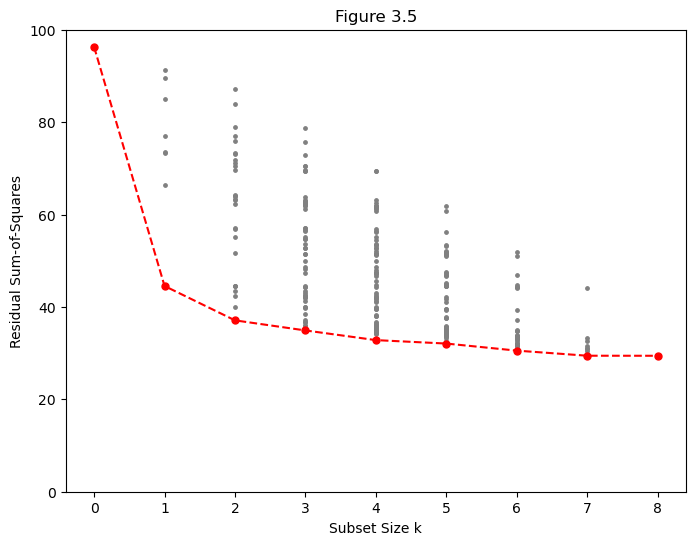

In [301]:
fig38 = plt.figure(figsize=(8, 6))

best_mask = df['best'] == 1
best = df[best_mask]
not_best = df[~best_mask]

plt.scatter(not_best['no. vars'], not_best['rss'], color='grey', s=6)
plt.plot(best['no. vars'], best['rss'], 'o--', color='red', markersize=5)

plt.ylim([0,100])

plt.xlabel('Subset Size k')
plt.ylabel('Residual Sum-of-Squares')
plt.title('Figure 3.5')

plt.show()